In [1]:
!pip install medmnist libauc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 5.0 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=59d3ac08036f757526f42a29c0e766dc4905d7ef7bdebc3775627c2dfcc55144
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from medmnist.dataset import ChestMNIST
from torchvision.models import resnet18
import numpy as np
from sklearn.metrics import precision_recall_curve, auc
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
def set_all_seeds(SEED):
   # REPRODUCIBILITY
   np.random.seed(SEED)
   torch.manual_seed(SEED)
   torch.cuda.manual_seed(SEED)
   torch.backends.cudnn.deterministic = True
   torch.backends.cudnn.benchmark = False
set_all_seeds(2023)

In [4]:
# Hyper-Parameters
lr = 1e-3
margin = 0.6
gamma = 0.1
weight_decay = 2e-4
total_epoch = 60
decay_epoch = [30, 45]
load_pretrain = False
batch_size=128

In [5]:
# Ustawienia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
learning_rate = 0.001
num_epochs = 20
target_class = 2  # Klasa docelowa do klasyfikacji binarnej

# Funkcja pomocnicza do obliczania AUC PRC
def compute_auc_prc(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    return auc(recall, precision)

# Transformacje danych
transform = Compose([
    ToTensor(),
    Normalize(mean=[0.5], std=[0.5]),
    Resize((32, 32))  # Opcjonalnie zmiana rozmiaru obrazu
])

# Ładowanie danych
train_dataset_raw = ChestMNIST(split='train', transform=transform, download=True)
val_dataset_raw = ChestMNIST(split='val', transform=transform, download=True)
test_dataset_raw = ChestMNIST(split='test', transform=transform, download=True)

100%|██████████| 82.8M/82.8M [00:08<00:00, 10.1MB/s]


Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz


In [6]:
# Przekształcanie etykiet na wartości binarne (1 dla klasy docelowej, 0 dla pozostałych)
def binarize_labels(dataset, target_class):
    dataset.labels = (dataset.labels.argmax(axis=1) == target_class).astype(float)
    return dataset

In [7]:
train_dataset_raw = binarize_labels(train_dataset_raw, target_class)
val_dataset_raw = binarize_labels(val_dataset_raw, target_class)
test_dataset_raw = binarize_labels(test_dataset_raw, target_class)

# Sprawdzanie niezbalansowania
train_labels = train_dataset_raw.labels
train_class_counts = Counter(train_labels)
print("Rozkład klas w zbiorze treningowym:", train_class_counts)

Rozkład klas w zbiorze treningowym: Counter({0.0: 72023, 1.0: 6445})


In [11]:
train_class_counts[0]

72023

In [ ]:
# DataLoadery
train_loader = DataLoader(
    train_dataset_raw, batch_size=batch_size, shuffle=True, num_workers=2
)
val_loader = DataLoader(
    val_dataset_raw, batch_size=batch_size, shuffle=False, num_workers=2
)
test_loader = DataLoader(
    test_dataset_raw, batch_size=batch_size, shuffle=False, num_workers=2
)

In [ ]:
def train_and_evaluate(critation):

  model = resnet18(pretrained=False)
  model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Dopasowanie do 1 kanału
  model.fc = nn.Sequential(
      nn.Linear(model.fc.in_features, 1),  # Klasyfikacja binarna
      nn.Sigmoid()
  )
  model = model.to(device)

  # Funkcja straty i optymalizator
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  # Trenowanie
  best_val_auc_prc = 0.0

  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0

      for images, labels in train_loader:
          images, labels = images.to(device), labels.float().to(device)  # Przekształcenie etykiet na float

          optimizer.zero_grad()
          outputs = model(images).squeeze()
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

      # Walidacja
      model.eval()
      val_true = []
      val_pred = []

      with torch.no_grad():
          for images, labels in val_loader:
              images, labels = images.to(device), labels.float().to(device)
              outputs = model(images).squeeze()
              val_true.extend(labels.cpu().numpy())
              val_pred.extend(outputs.cpu().numpy())

      val_auc_prc = compute_auc_prc(np.array(val_true), np.array(val_pred))
      print(f"Epoch [{epoch + 1}/{num_epochs}], Validation AUC PRC: {val_auc_prc:.4f}")

      # Zapis najlepszego modelu
      if val_auc_prc > best_val_auc_prc:
          best_val_auc_prc = val_auc_prc
          torch.save(model.state_dict(), "best_chestmnist_model.pth")
          print(f"Best model saved with AUC PRC: {best_val_auc_prc:.4f}")

  # Testowanie
  model.load_state_dict(torch.load("best_chestmnist_model.pth"))
  model.eval()

  test_true = []
  test_pred = []

  with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to(device), labels.float().to(device)
          outputs = model(images).squeeze()
          test_true.extend(labels.cpu().numpy())
          test_pred.extend(outputs.cpu().numpy())

  test_auc_prc = compute_auc_prc(np.array(test_true), np.array(test_pred))
  print(f"Test AUC PRC: {test_auc_prc:.4f}")


In [ ]:
pos_weight = torch.tensor([train_class_counts[0]+train_class_counts[1]/ train_class_counts[0]], dtype=torch.float)
criterion_wce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

trian_and_evaluate(criterion_wce)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/20], Loss: 0.2628
Epoch [1/20], Validation AUC PRC: 0.1801
Best model saved with AUC PRC: 0.1801
Epoch [2/20], Loss: 0.2489
Epoch [2/20], Validation AUC PRC: 0.2232
Best model saved with AUC PRC: 0.2232
Epoch [3/20], Loss: 0.2444
Epoch [3/20], Validation AUC PRC: 0.2286
Best model saved with AUC PRC: 0.2286
Epoch [4/20], Loss: 0.2398
Epoch [4/20], Validation AUC PRC: 0.2425
Best model saved with AUC PRC: 0.2425
Epoch [5/20], Loss: 0.2452
Epoch [5/20], Validation AUC PRC: 0.2242
Epoch [6/20], Loss: 0.2372
Epoch [6/20], Validation AUC PRC: 0.2562
Best model saved with AUC PRC: 0.2562
Epoch [7/20], Loss: 0.2334
Epoch [7/20], Validation AUC PRC: 0.2705
Best model saved with AUC PRC: 0.2705
Epoch [8/20], Loss: 0.2304
Epoch [8/20], Validation AUC PRC: 0.2651
Epoch [9/20], Loss: 0.2285
Epoch [9/20], Validation AUC PRC: 0.2589
Epoch [10/20], Loss: 0.2249
Epoch [10/20], Validation AUC PRC: 0.2611
Epoch [11/20], Loss: 0.2224
Epoch [11/20], Validation AUC PRC: 0.2695
Epoch [12/20], Loss:

<ipython-input-9-2394a196ed0e>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_chestmnist_model.pth"))


Test AUC PRC: 0.2623


=== Metryki Testowe === Binary Cross-Entropy Loss ==== 
AUC-PRC: 0.2623
AUC-ROC: 0.7915
Accuracy: 0.9182
Precision: 0.4769
Recall: 0.0169
F1-score: 0.0327

Confusion Matrix:
[[20567    34]
 [ 1801    31]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.92      1.00      0.96     20601
     Class 1       0.48      0.02      0.03      1832

    accuracy                           0.92     22433
   macro avg       0.70      0.51      0.49     22433
weighted avg       0.88      0.92      0.88     22433



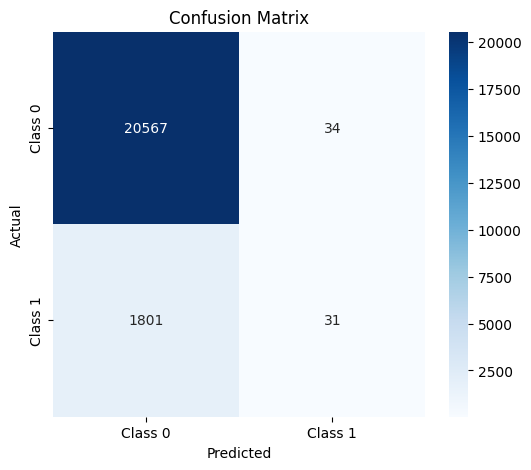

In [ ]:
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

import numpy as np

# Konwersja test_pred na NumPy array
test_pred = np.array(test_pred)


# Obliczanie dodatkowych metryk
test_pred_binary = (test_pred > 0.5).astype(int)  # Binarne prognozy (próg 0.5)

# AUC-ROC
test_roc_auc = roc_auc_score(test_true, test_pred)

# Accuracy, Precision, Recall, F1-score
test_accuracy = accuracy_score(test_true, test_pred_binary)
test_precision = precision_score(test_true, test_pred_binary)
test_recall = recall_score(test_true, test_pred_binary)
test_f1 = f1_score(test_true, test_pred_binary)

# Confusion Matrix
test_cm = confusion_matrix(test_true, test_pred_binary)

# Classification Report
test_report = classification_report(test_true, test_pred_binary, target_names=["Class 0", "Class 1"])

# Wyświetlanie wyników
print("=== Metryki Testowe === Binary Cross-Entropy Loss ==== ")
print(f"AUC-PRC: {test_auc_prc:.4f}")
print(f"AUC-ROC: {test_roc_auc:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_f1:.4f}")
print("\nConfusion Matrix:")
print(test_cm)
print("\nClassification Report:")
print(test_report)

# Wizualizacja Confusion Matrix
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import average_precision_score, classification_report
# Generowanie raportu dla najlepszego modelu
test_pred_binary = (np.array(test_pred) > 0.5).astype(int)  # Konwersja na klasy binarne
print("\nClassification Report:\n")
print(classification_report(test_true, test_pred_binary, target_names=["Not Target", "Target"]))



Classification Report:

              precision    recall  f1-score   support

  Not Target       0.92      1.00      0.96     20601
      Target       0.48      0.02      0.03      1832

    accuracy                           0.92     22433
   macro avg       0.70      0.51      0.49     22433
weighted avg       0.88      0.92      0.88     22433



In [ ]:
beta = 0.99999

In [ ]:
effective_num = 1.0 - np.power(beta, np.array(list(train_class_counts.values())))
class_weights_cb = (1.0 - beta) / effective_num
class_weights_cb /= class_weights_cb.sum()  # Normalizacja wag
print(f"Class weights (Class Balanced Loss): {class_weights_cb}")

# Klasa dla Class Balanced Loss
class ClassBalancedLoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.weights = torch.tensor(weights, dtype=torch.float32)

    def forward(self, logits, labels):
        # Przeniesienie wag na to samo urządzenie co logits
        weights = self.weights.to(logits.device)
        # Ustawienie wag dla klasy pozytywnej (1)
        pos_weight = weights[1]
        # Obliczenie straty
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        return criterion(logits, labels)

Class weights (Class Balanced Loss): [0.10840503 0.89159497]


In [ ]:
model = resnet18(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Dopasowanie do 1 kanału
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1)  # Klasyfikacja binarna
)
model = model.to(device)

# Funkcja straty i optymalizator
criterion = ClassBalancedLoss(class_weights_cb)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Trenowanie
best_val_ap = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)  # Przekształcenie etykiet na float

        optimizer.zero_grad()
        logits = model(images).squeeze()
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # Walidacja
    model.eval()
    val_true = []
    val_pred = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device)
            logits = model(images).squeeze()
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(torch.sigmoid(logits).cpu().numpy())

    val_ap = average_precision_score(np.array(val_true), np.array(val_pred))
    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Average Precision: {val_ap:.4f}")

    # Zapis najlepszego modelu
    if val_ap > best_val_ap:
        best_val_ap = val_ap
        torch.save(model.state_dict(), "best_chestmnist_model_cb.pth")
        print(f"Best model saved with Average Precision: {best_val_ap:.4f}")

# Testowanie
model.load_state_dict(torch.load("best_chestmnist_model_cb.pth"))
model.eval()

test_true = []
test_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        logits = model(images).squeeze()
        test_true.extend(labels.cpu().numpy())
        test_pred.extend(torch.sigmoid(logits).cpu().numpy())

test_ap = average_precision_score(np.array(test_true), np.array(test_pred))
print(f"Test Average Precision: {test_ap:.4f}")

# Generowanie raportu dla najlepszego modelu
test_pred_binary = (np.array(test_pred) > 0.5).astype(int)  # Konwersja na klasy binarne
print("\nClassification Report:\n")
print(classification_report(test_true, test_pred_binary, target_names=["Not Target", "Target"]))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/20], Loss: 0.2423
Epoch [1/20], Validation Average Precision: 0.2258
Best model saved with Average Precision: 0.2258
Epoch [2/20], Loss: 0.2298
Epoch [2/20], Validation Average Precision: 0.2302
Best model saved with Average Precision: 0.2302
Epoch [3/20], Loss: 0.2251
Epoch [3/20], Validation Average Precision: 0.2192
Epoch [4/20], Loss: 0.2227
Epoch [4/20], Validation Average Precision: 0.2601
Best model saved with Average Precision: 0.2601
Epoch [5/20], Loss: 0.2188
Epoch [5/20], Validation Average Precision: 0.2514
Epoch [6/20], Loss: 0.2160
Epoch [6/20], Validation Average Precision: 0.2675
Best model saved with Average Precision: 0.2675
Epoch [7/20], Loss: 0.2140
Epoch [7/20], Validation Average Precision: 0.2655
Epoch [8/20], Loss: 0.2113
Epoch [8/20], Validation Average Precision: 0.2400
Epoch [9/20], Loss: 0.2103
Epoch [9/20], Validation Average Precision: 0.2601
Epoch [10/20], Loss: 0.2066
Epoch [10/20], Validation Average Precision: 0.2897
Best model saved with Aver

<ipython-input-18-b920d2021b3b>:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_chestmnist_model_cb.pth"))


Test Average Precision: 0.2731

Classification Report:

              precision    recall  f1-score   support

  Not Target       0.92      1.00      0.96     20601
      Target       0.50      0.01      0.03      1832

    accuracy                           0.92     22433
   macro avg       0.71      0.51      0.49     22433
weighted avg       0.89      0.92      0.88     22433



=== Metryki Testowe === Class Balanced Loss ==== 
AUC-PRC: 0.2623
AUC-ROC: 0.8042
Accuracy: 0.9183
Precision: 0.5000
Recall: 0.0147
F1-score: 0.0286

Confusion Matrix:
[[20574    27]
 [ 1805    27]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.92      1.00      0.96     20601
     Class 1       0.50      0.01      0.03      1832

    accuracy                           0.92     22433
   macro avg       0.71      0.51      0.49     22433
weighted avg       0.89      0.92      0.88     22433



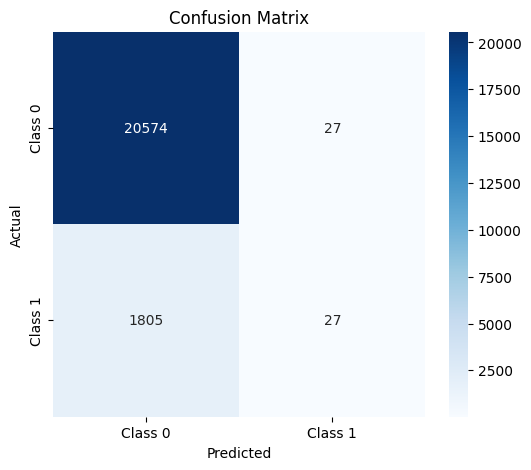

In [ ]:
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

test_pred = np.array(test_pred)

# Obliczanie dodatkowych metryk
test_pred_binary = (test_pred > 0.5).astype(int)  # Binarne prognozy (próg 0.5)

# AUC-ROC
test_roc_auc = roc_auc_score(test_true, test_pred)

# Accuracy, Precision, Recall, F1-score
test_accuracy = accuracy_score(test_true, test_pred_binary)
test_precision = precision_score(test_true, test_pred_binary)
test_recall = recall_score(test_true, test_pred_binary)
test_f1 = f1_score(test_true, test_pred_binary)

# Confusion Matrix
test_cm = confusion_matrix(test_true, test_pred_binary)

# Classification Report
test_report = classification_report(test_true, test_pred_binary, target_names=["Class 0", "Class 1"])

# Wyświetlanie wyników
print("=== Metryki Testowe === Class Balanced Loss ==== ")
print(f"AUC-PRC: {test_auc_prc:.4f}")
print(f"AUC-ROC: {test_roc_auc:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_f1:.4f}")
print("\nConfusion Matrix:")
print(test_cm)
print("\nClassification Report:")
print(test_report)

# Wizualizacja Confusion Matrix
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5):
        super().__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, logits, labels):
        probs = torch.sigmoid(logits)
        tp = (probs * labels).sum(dim=0)
        fp = ((1 - labels) * probs).sum(dim=0)
        fn = (labels * (1 - probs)).sum(dim=0)
        tversky = tp / (tp + self.alpha * fp + self.beta * fn + 1e-7)
        return 1 - tversky.mean()

criterion = TverskyLoss(alpha=0.3, beta=0.7)

In [ ]:
# Trenowanie
best_val_ap = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)  # Przekształcenie etykiet na float

        optimizer.zero_grad()
        logits = model(images).squeeze()
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # Walidacja
    model.eval()
    val_true = []
    val_pred = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device)
            logits = model(images).squeeze()
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(torch.sigmoid(logits).cpu().numpy())

    val_ap = average_precision_score(np.array(val_true), np.array(val_pred))
    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Average Precision: {val_ap:.4f}")

    # Zapis najlepszego modelu
    if val_ap > best_val_ap:
        best_val_ap = val_ap
        torch.save(model.state_dict(), "best_chestmnist_model_cb.pth")
        print(f"Best model saved with Average Precision: {best_val_ap:.4f}")

# Testowanie
model.load_state_dict(torch.load("best_chestmnist_model_cb.pth"))
model.eval()

test_true = []
test_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        logits = model(images).squeeze()
        test_true.extend(labels.cpu().numpy())
        test_pred.extend(torch.sigmoid(logits).cpu().numpy())

test_ap = average_precision_score(np.array(test_true), np.array(test_pred))
print(f"Test Average Precision: {test_ap:.4f}")

# Generowanie raportu dla najlepszego modelu
test_pred_binary = (np.array(test_pred) > 0.5).astype(int)  # Konwersja na klasy binarne
print("\nClassification Report:\n")
print(classification_report(test_true, test_pred_binary, target_names=["Not Target", "Target"]))

Epoch [1/20], Loss: 0.7021
Epoch [1/20], Validation Average Precision: 0.1510
Best model saved with Average Precision: 0.1510
Epoch [2/20], Loss: 0.6829
Epoch [2/20], Validation Average Precision: 0.1414
Epoch [3/20], Loss: 0.6857
Epoch [3/20], Validation Average Precision: 0.1355
Epoch [4/20], Loss: 0.6666
Epoch [4/20], Validation Average Precision: 0.1497
Epoch [5/20], Loss: 0.6684
Epoch [5/20], Validation Average Precision: 0.1461
Epoch [6/20], Loss: 0.6730
Epoch [6/20], Validation Average Precision: 0.1548
Best model saved with Average Precision: 0.1548
Epoch [7/20], Loss: 0.6709
Epoch [7/20], Validation Average Precision: 0.1242
Epoch [8/20], Loss: 0.6871
Epoch [8/20], Validation Average Precision: 0.1363
Epoch [9/20], Loss: 0.6811
Epoch [9/20], Validation Average Precision: 0.1454
Epoch [10/20], Loss: 0.6796
Epoch [10/20], Validation Average Precision: 0.1479
Epoch [11/20], Loss: 0.6728
Epoch [11/20], Validation Average Precision: 0.1445
Epoch [12/20], Loss: 0.6607
Epoch [12/20],

<ipython-input-22-694b3e506cae>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_chestmnist_model_cb.pth"))


Test Average Precision: 0.1556

Classification Report:

              precision    recall  f1-score   support

  Not Target       0.96      0.70      0.81     20601
      Target       0.17      0.69      0.27      1832

    accuracy                           0.70     22433
   macro avg       0.56      0.69      0.54     22433
weighted avg       0.90      0.70      0.76     22433



=== Metryki Testowe === Tversky Loss ==== 
AUC-PRC: 0.2623
AUC-ROC: 0.6901
Accuracy: 0.6954
Precision: 0.1674
Recall: 0.6867
F1-score: 0.2691

Confusion Matrix:
[[14342  6259]
 [  574  1258]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      0.70      0.81     20601
     Class 1       0.17      0.69      0.27      1832

    accuracy                           0.70     22433
   macro avg       0.56      0.69      0.54     22433
weighted avg       0.90      0.70      0.76     22433



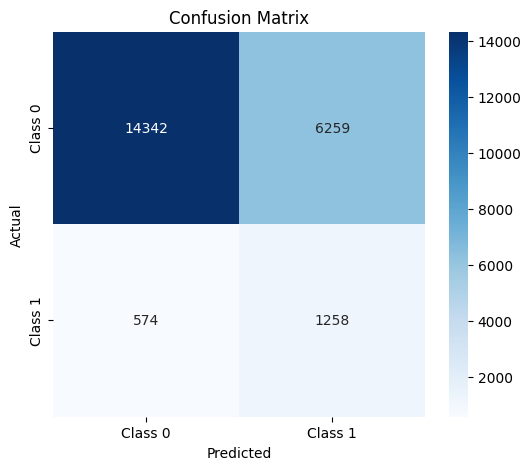

In [ ]:
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)
test_pred = np.array(test_pred)

# Obliczanie dodatkowych metryk
test_pred_binary = (test_pred > 0.5).astype(int)  # Binarne prognozy (próg 0.5)

# AUC-ROC
test_roc_auc = roc_auc_score(test_true, test_pred)

# Accuracy, Precision, Recall, F1-score
test_accuracy = accuracy_score(test_true, test_pred_binary)
test_precision = precision_score(test_true, test_pred_binary)
test_recall = recall_score(test_true, test_pred_binary)
test_f1 = f1_score(test_true, test_pred_binary)

# Confusion Matrix
test_cm = confusion_matrix(test_true, test_pred_binary)

# Classification Report
test_report = classification_report(test_true, test_pred_binary, target_names=["Class 0", "Class 1"])

# Wyświetlanie wyników
print("=== Metryki Testowe === Tversky Loss ==== ")
print(f"AUC-PRC: {test_auc_prc:.4f}")
print(f"AUC-ROC: {test_roc_auc:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_f1:.4f}")
print("\nConfusion Matrix:")
print(test_cm)
print("\nClassification Report:")
print(test_report)

# Wizualizacja Confusion Matrix
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
